In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.lines as mlines
import os
import matplotlib as mpl
from PIL import Image
from io import BytesIO
mpl.rc('figure', dpi=400, figsize=(10,10))
mpl.rc('savefig', dpi=400)
import numpy as np

from math import log10, floor

def round_sig(x, sig=1):
    """Round a value to N sig fig.

    Parameters
    ----------
    x : float
        Value to round
    sig : int, optional
        Number of sig figs, default is 1

    Returns
    -------
    float
        Rounded value

    """
    return round(x, sig - int(floor(log10(abs(x)))) - 1)

In [0]:
project_id = 'hypothermia-bayescmd'
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

In [0]:
LWP479_query = """
SELECT
  Q_10_met,
  Xtot_n,
  r_n,
  r_0,
  K_sigma,
  pH_mn,
  phi,
  Q_10_haemo,
  a_frac_n,
  _L0n,
  NADpool,
  NRMSE,
  "LWP479" as model_name
FROM
  LWP479.bph2_1
ORDER BY
  NRMSE ASC
LIMIT
  50000
"""

In [0]:
LWP475_query = """
SELECT
  Q_10_met,
  Xtot_n,
  r_n,
  r_0,
  K_sigma,
  pH_mn,
  phi,
  Q_10_haemo,
  a_frac_n,
  _L0n,
  NADpool,
  NRMSE,
  "LWP475" as model_name
 FROM 
  LWP475.bph2
 ORDER BY NRMSE ASC 
 LIMIT 50000
 """

In [0]:
df475 = client.query(LWP475_query).to_dataframe()

In [0]:
df479 = client.query(LWP479_query).to_dataframe()

In [0]:
df = pd.concat([df475, df479])
df.head()

,Q_10_met,Xtot_n,r_n,r_0,K_sigma,pH_mn,phi,Q_10_haemo,a_frac_n,_L0n,NADpool,NRMSE,model_name
0,5.970293,3.508829,0.016543,0.011463,10.709943,7.590019,0.042537,5.107728,0.267134,2.005650,2.863109,0.529548,LWP475
1,5.654066,3.562840,0.016052,0.010375,9.080127,7.221708,0.039155,5.957969,0.259468,1.807104,2.799367,0.532384,LWP475
2,5.949750,3.638107,0.015911,0.011343,11.833022,7.532510,0.036487,2.298373,0.235298,2.045118,3.713031,0.534158,LWP475
3,5.957734,3.816738,0.016815,0.011159,9.736500,7.259544,0.041115,5.221975,0.313899,1.727716,3.799454,0.534779,LWP475
4,5.885335,3.505254,0.015355,0.010214,9.497623,7.283493,0.039508,1.970205,0.270574,3.675052,3.877752,0.534832,LWP475


In [0]:
priors =  {
        "Q_10_met": [
            "uniform",
            [
                0.01,
                6.0
            ]
        ],
        "Xtot_n": [
            "uniform",
            [
                3.5,
                8.0
            ]
        ],
        "r_n": [
            "uniform",
            [
                0.01496,
                0.02244
            ]
        ],
        "r_0": [
            "uniform",
            [
                0.01008,
                0.015119999999999998
            ]
        ],
        "K_sigma": [
            "uniform",
            [
                8.0,
                12.0
            ]
        ],
        "pH_mn": [
            "uniform",
            [
                7.2,
                7.6
            ]
        ],
        "phi": [
            "uniform",
            [
                0.0288,
                0.0432
            ]
        ],
        "Q_10_haemo": [
            "uniform",
            [
                0.01,
                6.0
            ]
        ],
        "a_frac_n": [
            "uniform",
            [
                0.0,
                1.0
            ]
        ],
        "_L0n": [
            "uniform",
            [
                0.1,
                5.0
            ]
        ],
        "NADpool": [
            "uniform",
            [
                1.5,
                4.5
            ]
        ]
}

In [0]:
def plot_comparison_diag_medians(g, df, medians):

    for i, var in enumerate(g.x_vars):
        ax = g.axes[i][i]
        LWP475_median = np.median(df[var][df['model_name']=='LWP475'])
        ax.axvline(LWP475_median, color=sns.color_palette()[0], linewidth=2)
        
        LWP479_median = np.median(df[var][df['model_name']=='LWP479'])
        ax.axvline(LWP479_median, color=sns.color_palette()[1], linewidth=2)
        
        
        ax.text(
            0.05,
            1.45,
            "LWP475: {:.3g}\nLWP479: {:.3g}".format(LWP475_median,
                                                    LWP479_median),
            verticalalignment='center',
            transform=ax.transAxes,
            fontsize=8)
        


    return True

In [0]:
def medians_comparison_kde_plot(x, y, medians, **kws):
    """Plot bivariate KDE with median of distribution marked on,
    comparing between groups.

    Parameters
    ----------
    x : array-like
        Array-like of data to plot.
    y : array-like
        Array-like of data to plot.
    medians : :obj:`dict`
        Dictionary of parameter, median pairings.
    kws : key, value pairings.
        Other keyword arguments to pass to :obj:`sns.distplot`.

    Returns
    -------
    ax : :obj:`matplotlib.AxesSubplot`
        AxesSubplot object of univariate KDE and bar plot with median marked
        on as well as text.

    """
    ax = plt.gca()
    ax = sns.kdeplot(x, y, ax=ax, **kws)
    # color = infer_from_cmap(kws['cmap'])
    x_median = x.median()
    y_median = y.median()
    ax.plot(x_median, y_median, 'X', markerfacecolor=kws['color'],
            markeredgecolor='k', markeredgewidth=1.5, markersize=6)
    return ax

/usr/local/lib/python3.6/dist-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


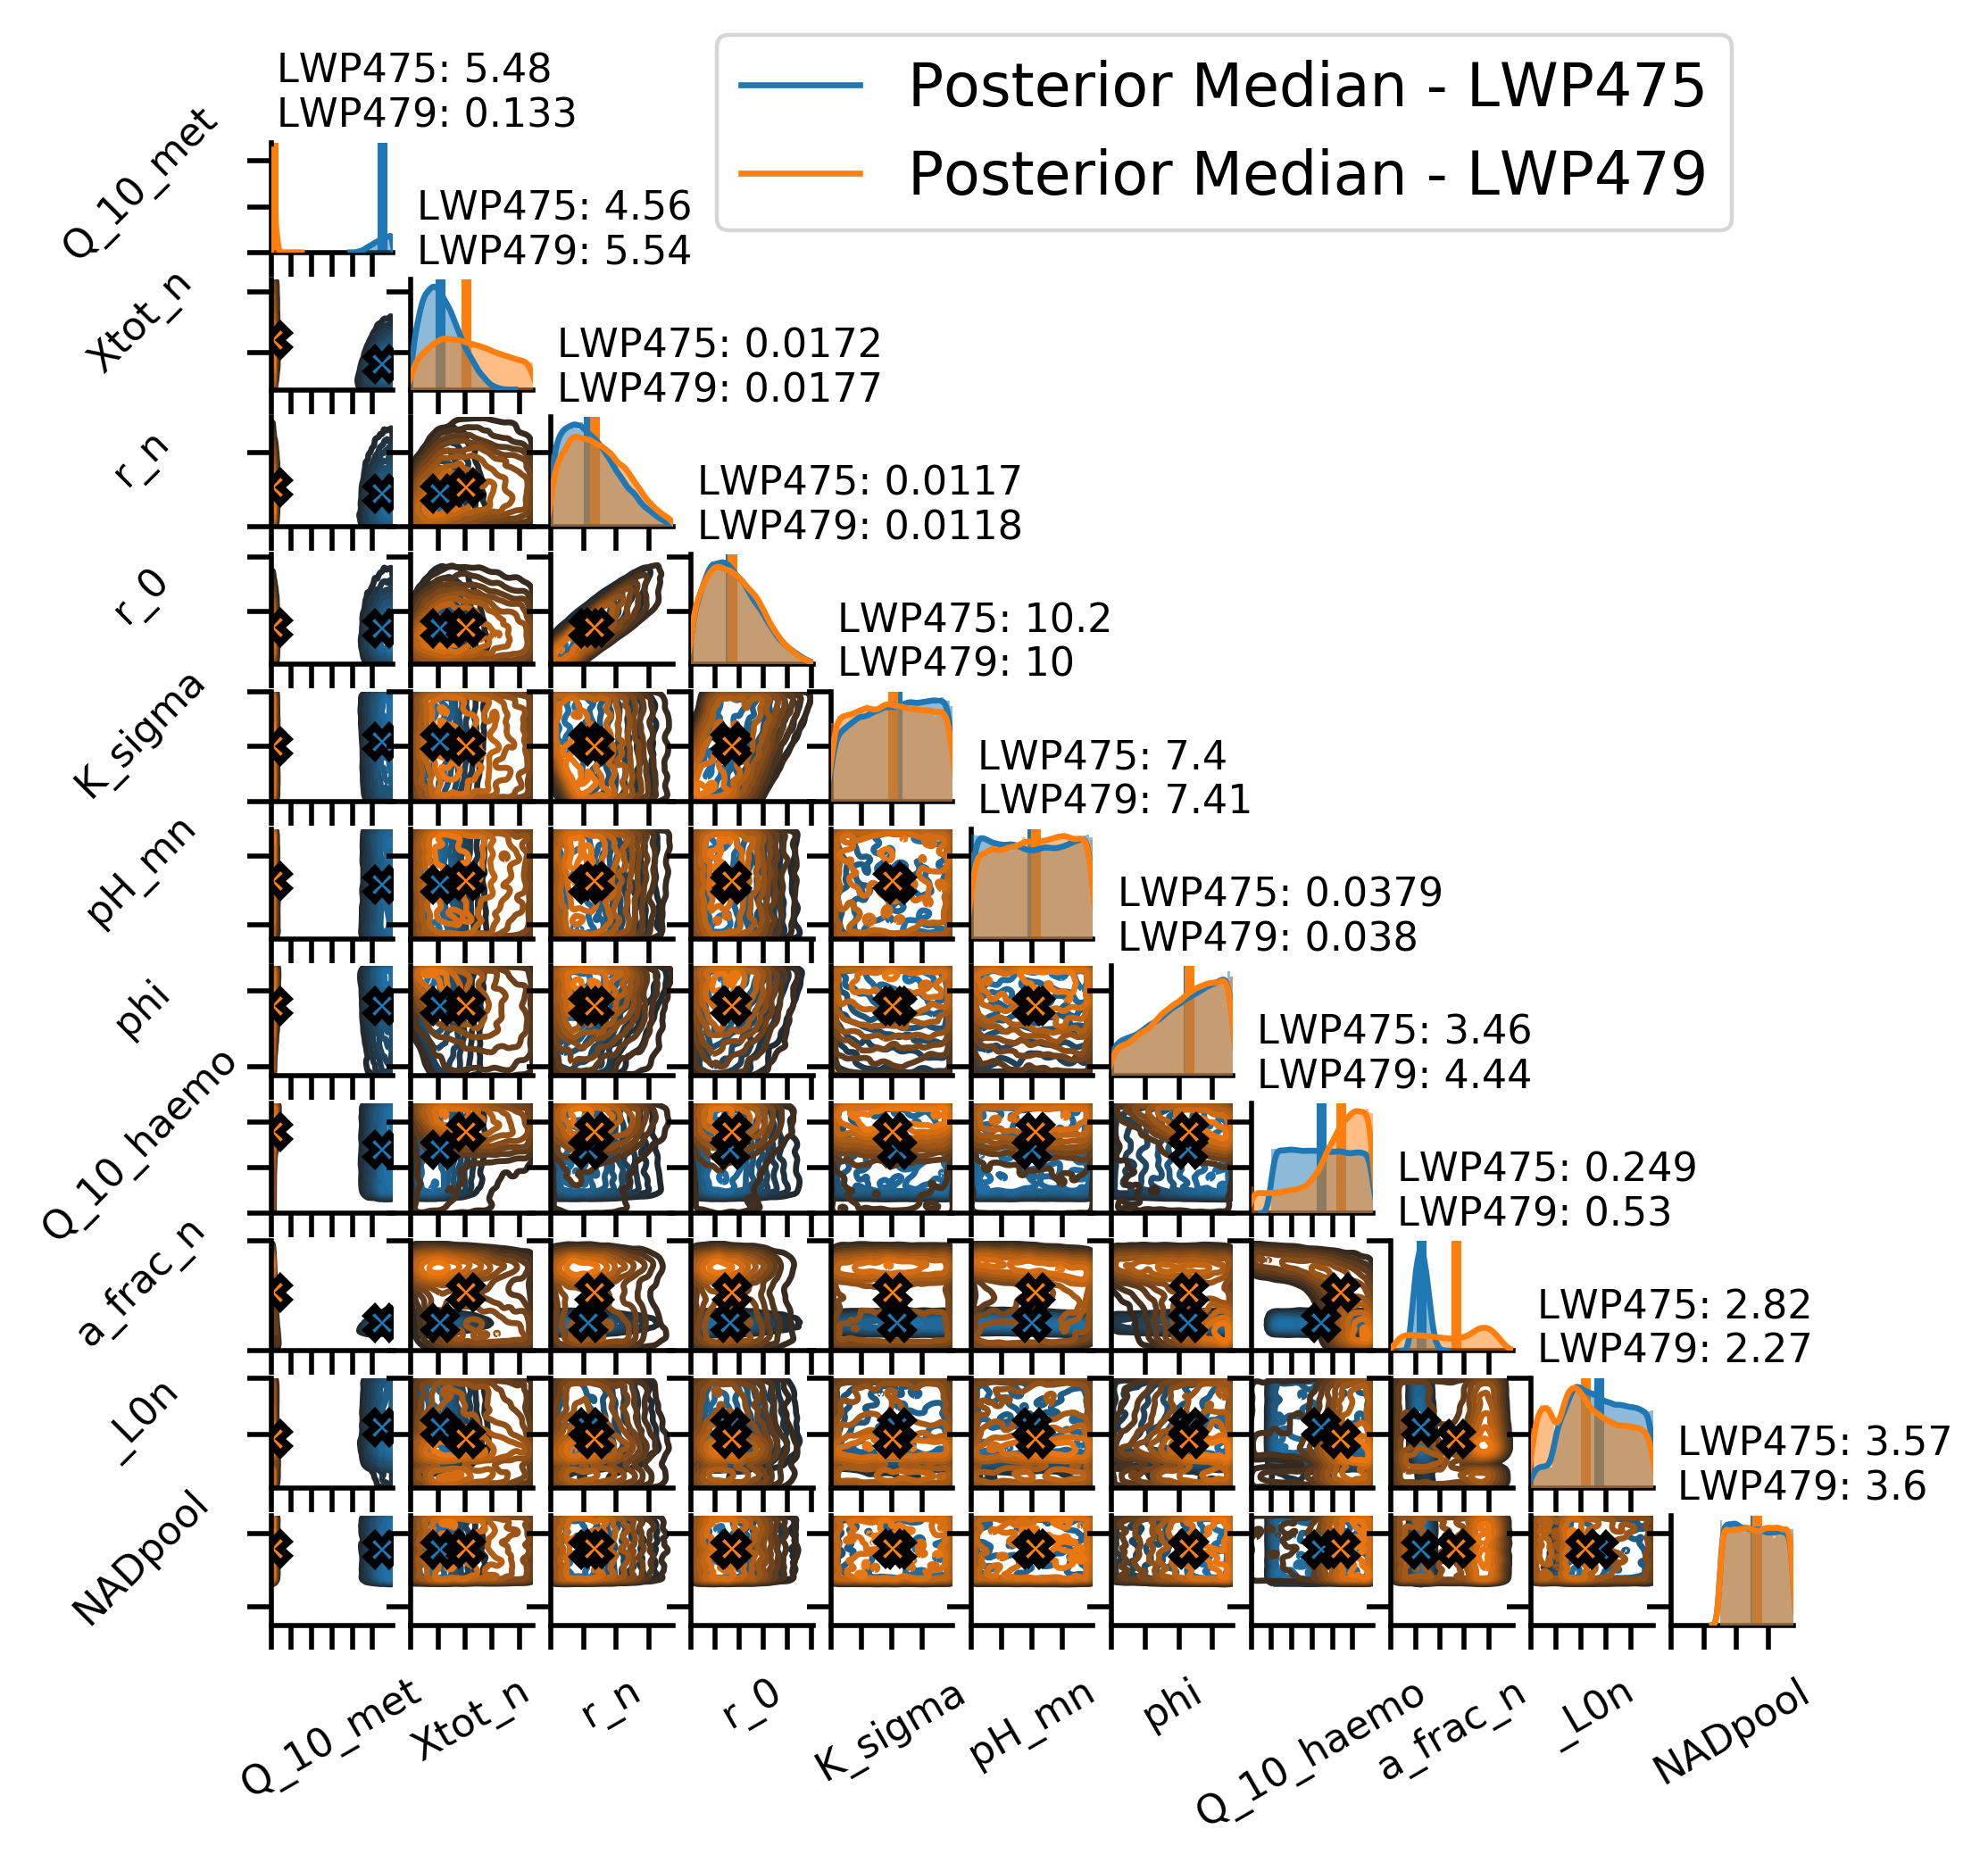

In [0]:
parameters= list(priors.keys())
medians={}
with sns.plotting_context("paper", rc={"xtick.labelsize": 12,
                                       "ytick.labelsize": 12,
                                       "axes.labelsize": 12}):   
    g = sns.PairGrid(df,
                     vars=parameters,
                     diag_sharey=False,
                     height=0.5,
                     hue='model_name')
    
    g.map_diag(sns.distplot, hist_kws=dict(alpha=0.5))
    plot_comparison_diag_medians(g, df, medians=medians)
    g.map_lower(medians_comparison_kde_plot, medians=medians)
    n_ticks=4
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)
    for ii, ax in enumerate(g.axes.flat):
        for label in ax.get_xticklabels():
            label.set_rotation(75)
        ax.xaxis.labelpad=5
        ax.yaxis.labelpad=5
        ii_y = ii // len(parameters)
        ii_x = ii % len(parameters)
        ax.set_ylim(priors[parameters[ii_y]][1])
        ax.set_xlim(priors[parameters[ii_x]][1])
        xmax = priors[parameters[ii_x]][1][1]
        xmin = priors[parameters[ii_x]][1][0]
        xticks = np.arange(xmin, xmax,
                           round_sig((xmax - xmin) / n_ticks, sig=1))
        ax.set_xticks(xticks)
        ax.set_xlabel(ax.get_xlabel(), labelpad=1, rotation=30, fontsize=8)
        ax.set_ylabel(ax.get_ylabel(), labelpad=15, rotation=45, fontsize=8)
    lines = []
    # lines.append(('True Value', mlines.Line2D([], [], color='black')))
    lines.append(('Posterior Median - LWP475', mlines.Line2D([], [], color=sns.color_palette()[0])))
    lines.append(('Posterior Median - LWP479', mlines.Line2D([], [], color=sns.color_palette()[1])))
    g.set(yticklabels=[])
    g.set(xticklabels=[])
    g.fig.legend(labels=[l[0] for l in lines],
                 handles=[l[1] for l in lines],
                 bbox_to_anchor=(0.35, 0.95), loc=2, prop={"size": 12})

    # g.fig.tight_layout()
    g.fig.subplots_adjust(wspace=0.15, hspace=0.25)

In [0]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
g.savefig('/content/gdrive/My Drive/Colab Notebooks/comparison_posteriors.png')

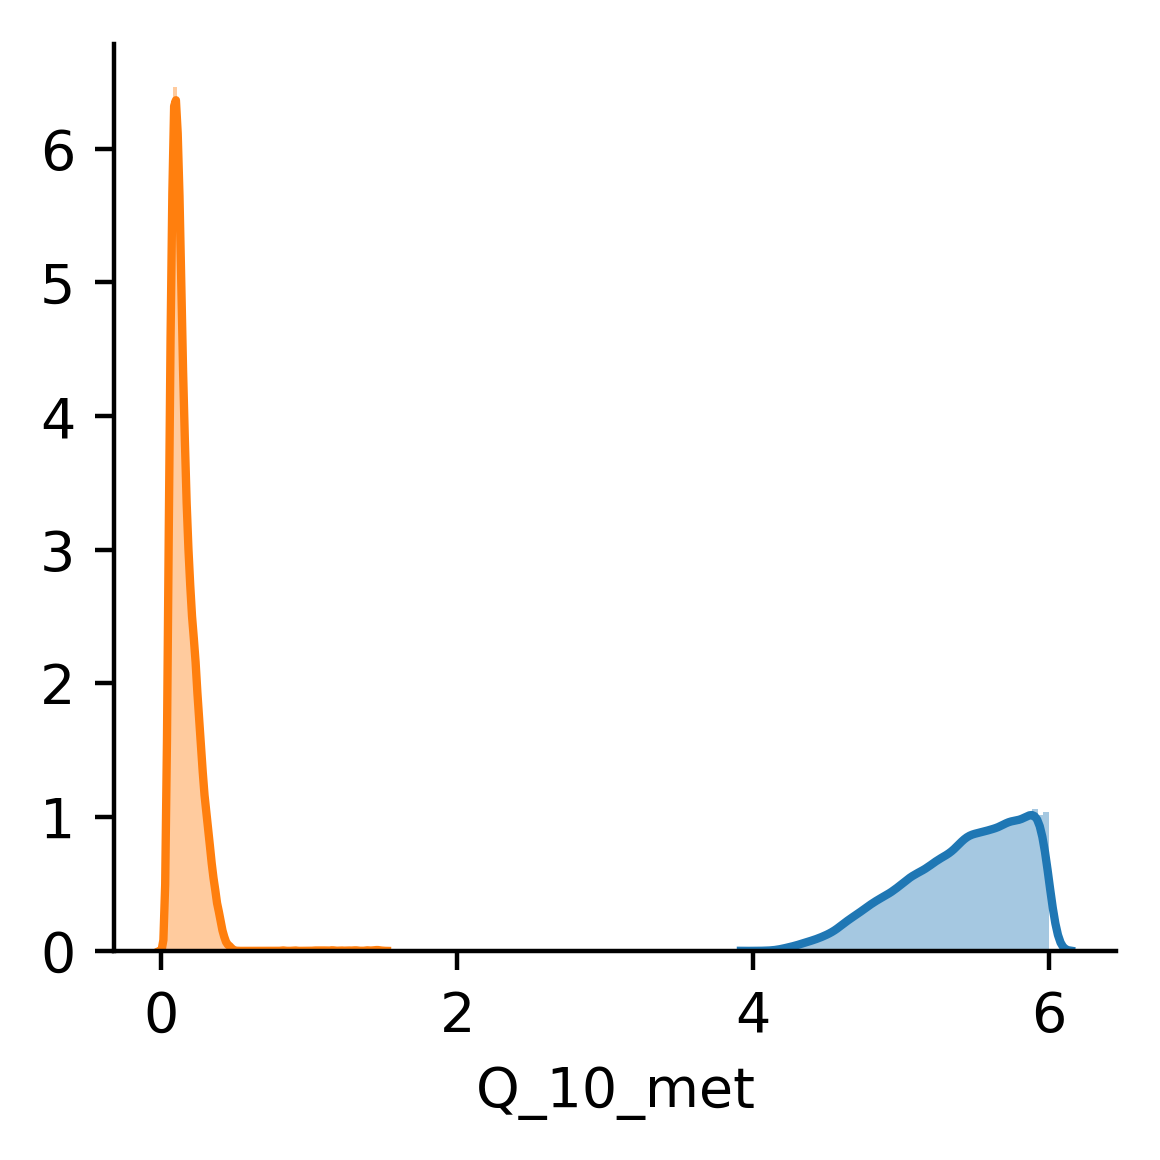

In [0]:
g = sns.FacetGrid(df, hue='model_name', height=3)
g = (g.map(sns.distplot, 'Q_10_met'))

In [0]:
g.savefig('/content/gdrive/My Drive/Colab Notebooks/Q_10_met_marginal.png')